# DE-test-no-impute-sandbox
2.1.23

What happens when I add in the "no impute" condition? 

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy import stats
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_curve

# suppressing this CUDA initialization warning I always get
    # this could be dangerous
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# import my modules
sys.path.append('../../../../bin/')
from models.linear import GradNMFImputer
import util_functions
import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Configs

In [2]:
# partitioning params
val_frac = 0.3
test_frac = 0.0
# setting this to 0 ensures that no peptides will be filtered out
min_present = 0     # during partitioning
q_anchor=0.5  # these three for MNAR partition 
t_std=0.8
brnl_prob=0.9

# NMF model params
n_factors = 4
tolerance = 0.0001            # 0.0001 is default
max_epochs = 1000             # 1000 is default
learning_rate = 0.01          # 0.01 is default
batch_size = 64               # 64 is default
loss_func = "MSE"

# kNN impute params
k_neighbors = 4

# for determining the ground truth DE peptides.
    # also the significance threshold for calling imputed DE peptides
alpha = 0.01
correction = "BH"

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

#### Read in the peptide quants dataframes, preprocess

In [3]:
# read in 
cond1_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-ADD-quants.csv")
cond2_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-HCF-low-quants.csv")

# get the list of peptide IDs, or rather transition group IDs
    # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["pids"])

# now remove the peptide ID columns
to_remove = ["pids"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

condition 1 quants:  (32614, 9)
condition 2 quants:  (32614, 9)


#### Get the ground truth DE peptides

In [4]:
# get ground truth DE peptides
reject_null_gt, pvals_correct = \
            util_functions.find_DE_peptides(
                                cond1_quants, 
                                cond2_quants, 
                                correction, 
                                alpha
)
DE_peptides_gt = list(peptide_ids[reject_null_gt])

#### Combine, store n_cols cutoff

In [5]:
# create the combined matrix, to use for imputation 
comb_quants = np.concatenate([cond1_quants, cond2_quants], axis=1)

# this is for eventually separating the reconstructed matrices 
    # into normal and tumor matrices
cols_cutoff = cond1_quants.shape[1]

#### Partition

In [6]:
# MCAR partition 
# train, val, test = util_functions.split(
#                                     comb_quants, 
#                                     val_frac=val_frac,
#                                     test_frac=test_frac, 
#                                     min_present=min_present,
#                                     random_state=split_rand_state,
# )
# MNAR partition 
train, val = util_functions.MNAR_partition_thresholds_matrix(
                                    comb_quants, 
                                    q_anchor=q_anchor, 
                                    t_std=t_std, 
                                    brnl_prob=brnl_prob, 
                                    min_pres=min_present,
                                    rand_state=split_rand_state,
)

#### Get the optimal n_batches for NMF training

In [7]:
# get the optimal number of batches for training
if len(~np.isnan(train)) > 100:
    n_batches = int(np.floor(len(~np.isnan(train)) / batch_size))
    # setting the minimum n_batches to 100
    n_batches = max(n_batches, 100) 
else: 
    n_batches = 1
    
print(n_batches)

509


#### Get the missingness fractions

In [8]:
# get the missingness fractions
orig_mv_frac = np.count_nonzero(np.isnan(comb_quants)) / comb_quants.size
train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

print("original mv frac: ", np.around(orig_mv_frac, decimals=2))
print("training mv frac: ", np.around(train_mv_frac, decimals=2))
print("validation mv frac: ", np.around(val_mv_frac, decimals=2))

original mv frac:  0.0
training mv frac:  0.45
validation mv frac:  0.55


***

## Impute with various methods

#### NMF impute

In [9]:
# init model 
nmf_model = GradNMFImputer(
                n_rows = train.shape[0], 
                n_cols = train.shape[1], 
                n_factors=n_factors, 
                stopping_tol=tolerance,
                train_batch_size=n_batches, 
                eval_batch_size=n_batches,
                n_epochs=max_epochs, 
                loss_func=loss_func,
                optimizer=torch.optim.Adam,
                optimizer_kwargs={"lr": learning_rate},
                non_negative=True,
                rand_seed=rng.random(),
)
# fit and transform
nmf_recon = nmf_model.fit_transform(train, val)
nmf_full_recon = nmf_model.train_set_transform(train)

  3%|▎         | 31/1000 [00:41<21:50,  1.35s/epoch]

early stopping triggered: wilcoxon criteria


#### kNN impute

In [10]:
# knn_model = KNNImputer(n_neighbors=k_neighbors)
# knn_recon = knn_model.fit_transform(train)

#### Sample min impute

In [11]:
col_min = np.nanmin(train, axis=0)
nan_idx = np.where(np.isnan(train))
smin_recon = train.copy()
# nan_idx[1] -> take index of column
smin_recon[nan_idx] = np.take(col_min, nan_idx[1]) 

#### Gaussian sample impute

In [12]:
# get the column mins
col_min = np.nanmin(train, axis=0)

# get the mean and std of the entire training matrix
train_mean = np.nanmean(train)
train_sd = np.nanstd(train)

# get the indicies of the MVs 
nan_idx = np.where(np.isnan(train))
gsample_recon = train.copy()

# how many total MVs? 
n_mv = len(nan_idx[0])

# fill in the MVs with random draws 
gsample_recon[nan_idx] = rng.normal(
                            loc=np.mean(col_min), 
                            scale=np.std(col_min), 
                            size=n_mv
)

# don't want negative values
gsample_recon = np.abs(gsample_recon)

***

## Precision Recall curve plotting

#### Separate the recon matrices into the two experimental conditions
Including no impute. 

In [13]:
# for the NMF model 
cond1_recon_nmf = nmf_recon[:,0:cols_cutoff]
cond2_recon_nmf = nmf_recon[:,cols_cutoff:]

# for the kNN model 
# cond1_recon_knn = knn_recon[:,0:cols_cutoff]
# cond2_recon_knn = knn_recon[:,cols_cutoff:]

# for min impute
cond1_recon_smin = smin_recon[:,0:cols_cutoff]
cond2_recon_smin = smin_recon[:,cols_cutoff:]

# for random sample impute
cond1_recon_gsample = gsample_recon[:,0:cols_cutoff]
cond2_recon_gsample = gsample_recon[:,cols_cutoff:]

# for no impute
no_impute_mat = train.copy()
cond1_noimp = no_impute_mat[:,0:cols_cutoff]
cond2_noimp = no_impute_mat[:,cols_cutoff:]

#### Get the corrected p-values for every model's reconstruction

In [14]:
r, cp_vals_nmf = util_functions.find_DE_peptides(
                        cond1_recon_nmf, cond2_recon_nmf, 
                        correction, alpha_=alpha)
# r, cp_vals_knn = util_functions.find_DE_peptides(
#                         cond1_recon_knn, cond2_recon_knn, 
#                         correction, alpha_=alpha)
r, cp_vals_smin = util_functions.find_DE_peptides(
                        cond1_recon_smin, cond2_recon_smin, 
                        correction, alpha_=alpha)
r, cp_vals_gsample = util_functions.find_DE_peptides(
                        cond1_recon_gsample, cond2_recon_gsample, 
                        correction, alpha_=alpha)
r, cp_vals_noimp = util_functions.find_DE_peptides(
                        cond1_noimp, cond2_noimp, 
                        correction, alpha_=alpha)

/net/noble/vol2/home/lincolnh/.local/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


#### Get the DE probabilities

In [15]:
# the ground truth labels. True means DE peptide, False means not
gt_labels = reject_null_gt.astype(float)

# get the DE probabilities, for each model 
prob_true_nmf = 1 - cp_vals_nmf
# prob_true_knn = 1 - cp_vals_knn
prob_true_smin = 1 - cp_vals_smin
prob_true_gsample = 1 - cp_vals_gsample
prob_true_noimp = 1 - cp_vals_noimp

#### Get the Precision Recall stats
With the sklearn PR plotting function 

In [17]:
pr_nmf, recall_nmf, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf)
# pr_knn, recall_knn, t = precision_recall_curve(
#                         y_true=gt_labels, probas_pred=prob_true_knn)
pr_smin, recall_smin, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_smin)
pr_gsample, recall_gsample, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_gsample)
pr_noimp, recall_noimp, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_noimp)

#### Get the AUCs

In [18]:
nmf_auc = np.around(auc(recall_nmf, pr_nmf), 2)
# knn_auc = np.around(auc(recall_knn, pr_knn), 2)
smin_auc = np.around(auc(recall_smin, pr_smin), 2)
gsample_auc = np.around(auc(recall_gsample, pr_gsample), 2)
noimp_auc = np.around(auc(recall_noimp, pr_noimp), 2)

#### Plot

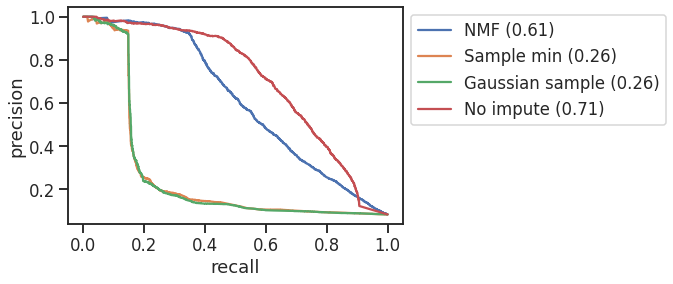

In [19]:
# plot
plt.figure()

plt.plot(
    recall_nmf, pr_nmf, label="NMF (" + str(nmf_auc) + ")")
# plt.plot(
#   recall_knn, pr_knn, label="kNN (" + str(knn_auc) + ")")
plt.plot(
    recall_smin, pr_smin, 
    label="Sample min (" + str(smin_auc) + ")")
plt.plot(
    recall_gsample, pr_gsample, 
    label="Gaussian sample (" + str(gsample_auc) + ")")
plt.plot(
    recall_noimp, pr_noimp, 
    label="No impute (" + str(noimp_auc) + ")")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

***

#### Check on these guys
I'm guessing the second one will have a completely masked array. 
Looks like one of the arrays has only a single observation. 

In [20]:
#cond1_noimp[0]
#cond2_noimp[0]

In [21]:
#cond1_noimp[1]
#cond2_noimp[1]